In [74]:
library(tidyverse)
library(ggtree)
library(ggnewscale)

In [2]:
mdist = read_tsv("distances.tsv.xz", col_names = c("fq1", "fq2", "dist", "pval", "shared"))

Rows: 827541 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): fq1, fq2, shared
dbl (2): dist, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
dntax = read_csv("https://github.com/borevitzlab/cca-eucs/raw/master/metadata/originals/DNTaxonomyCleaned.csv")

Rows: 1159 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Binomial, Genus, Subgenus, Section, Series, Subseries, Species, Sub...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
spp = read_tsv("../alleuc_sample_metadata.tsv") %>%
    select(sample, species) %>%
    left_join(
        dntax %>% select(Binomial, Section),
        by=join_by(species==Binomial)
    ) %>%
    mutate(species2=sub(" subsp.*", "", species))

Rows: 3836 Columns: 15
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (10): sample, project, species, datum, location, collectors, population...
dbl   (4): latitude, longitude, elevation, percent_dieback
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
str(spp)

tibble [3,836 × 4] (S3: tbl_df/tbl/data.frame)
 $ sample  : chr [1:3836] "Acacia_acuminata_ANBG" "Acacia_dealbata" "Acacia_melanoxylon" "FDK10" ...
 $ species : chr [1:3836] NA NA NA "Eucalyptus microcarpa" ...
 $ Section : chr [1:3836] NA NA NA "Adnataria" ...
 $ species2: chr [1:3836] NA NA NA "Eucalyptus microcarpa" ...


In [6]:
meta = read_tsv("dieback_only.tsv")
meta = meta %>% 
    filter(
        !grepl("^NCT", sample),
        !if_all(read1:interleaved, is.na),
    ) %>%
    select(sample) %>%
    left_join(spp, by=join_by(sample))

Rows: 1444 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): library, sample, read1, read2, interleaved

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in left_join(., spp, by = join_by(sample)):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 6 of `x` matches multiple rows in `y`.
ℹ Row 176 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [7]:
fdist = mdist %>%
    transmute(
        samp1 = sub("tmp/(.+).fastq.gz", "\\1", fq1),
        samp2 = sub("tmp/(.+).fastq.gz", "\\1", fq2),
        dist=dist,
    )

In [13]:
fdmat = bind_rows(fdist, rename(fdist, samp2=samp1, samp1=samp2)) %>%
        pivot_wider(names_from = "samp2", values_from = "dist") %>%
        column_to_rownames("samp1") %>%
        as.matrix()
fdmat[is.na(fdmat)] = 0
fdmat = fdmat[colnames(fdmat),]

In [14]:
write.csv(fdmat, "full-distance-matrix-square.csv")

In [15]:
str(fdmat)

 num [1:1287, 1:1287] 0 0.1448 0.0567 0.0965 0.0623 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:1287] "Eucalyptus_viminalis_Tasmanian_Herbarium" "NCT" "NCT_1" "NCT_3" ...
  ..$ : chr [1:1287] "Eucalyptus_viminalis_Tasmanian_Herbarium" "NCT" "NCT_1" "NCT_3" ...


In [8]:
str(fdist)

tibble [827,541 × 3] (S3: tbl_df/tbl/data.frame)
 $ samp1: chr [1:827541] "NCT" "NCT_1" "NCT_1" "NCT_3" ...
 $ samp2: chr [1:827541] "Eucalyptus_viminalis_Tasmanian_Herbarium" "Eucalyptus_viminalis_Tasmanian_Herbarium" "NCT" "Eucalyptus_viminalis_Tasmanian_Herbarium" ...
 $ dist : num [1:827541] 0.1448 0.0567 0.124 0.0965 0.1131 ...


In [39]:
rep.samp = colnames(fdmat)[grepl("^MON.*_1$", colnames(fdmat))] %>% sub("_1$", "", .)
m = colnames(fdmat)[grepl(paste(rep.samp, collapse="|"),  colnames(fdmat))]
hc = fdmat[m, m] %>%
    as.dist() %>%
    hclust()



In [66]:
fqsum = read_tsv("../fqstat_with_metadata.tsv")
yielddat = fqsum %>%
    filter(library %in% m, !is.na(fqfile)) %>%
    select( sample, seqproject, read, fqfile,n_bases)   %>%
    mutate(fqbase=fqfile %>% basename() %>% sub("_R[12]_", "_", .), mbp = n_bases/1e6) %>%
    group_by(sample, seqproject, fqbase) %>%
    summarise(mbp=sum(mbp)) %>%
    select(sample, mbp)

Rows: 24441 Columns: 37
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (27): library, sample, project, seq_date, species, datum, location, col...
dbl   (8): latitude, longitude, elevation, n, time, percent_dieback, n_reads...
date  (2): date, parsed_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'sample', 'seqproject'. You can override using the `.groups` argument.
Adding missing grouping variables: `seqproject`


In [69]:
df = select(spp, sample, species2) %>%
    filter(grepl(paste(rep.samp, collapse="|"), sample), !is.na(species2)) %>%
    right_join(tibble(library=m) %>% mutate(sample=sub("_1$", "", library)), by="sample") %>%
    left_join(yielddat, by=join_by(library==sample)) %>%
    select(library, Species=species2, Seq_Yield=mbp) %>%
    column_to_rownames("library")

In [70]:
df

,Species,Seq_Yield
,<chr>,<dbl>
MON0003,Eucalyptus dives,13028.10967
MON0003_1,Eucalyptus dives,11003.92115
MON0016,Eucalyptus viminalis,10377.13827
MON0016_1,Eucalyptus viminalis,12462.11335
MON0048,Eucalyptus pauciflora,10205.12330
MON0048_1,Eucalyptus pauciflora,11593.80869
MON0065,Eucalyptus rubida,9391.33326
MON0065_1,Eucalyptus rubida,9187.05925
MON0105,Eucalyptus viminalis,37.11369


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


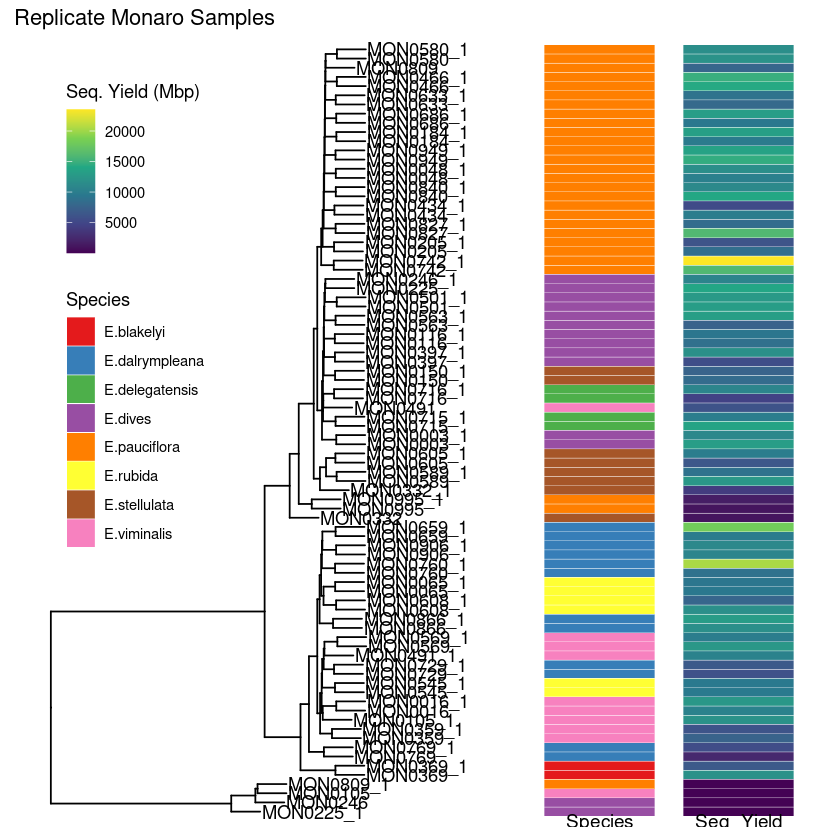

In [102]:
p = ggtree(hc)  %<+% df  +
    geom_tiplab()

#p1 = gheatmap(p, select(df, Species), colnames=T, offset=.1, width=.3) +
#    scale_fill_brewer(palette="Set1") +
#    labs(fill="Species", title="Replicate Monaro Samples")
#
#+

p1 = gheatmap(p, select(df, Species) %>% mutate(Species=sub("Eucalyptus ", "E.", Species)), offset=.15, width=.35) +
    scale_fill_brewer(palette="Set1", name="Species") +
    new_scale_fill()
gheatmap(p1, transmute(df, Seq_Yield), offset=.32, width=.35)+
    scale_fill_viridis_c(option="D", name="Seq. Yield (Mbp)") +
    labs(fill="Species", title="Replicate Monaro Samples") +
    theme(legend.position = c(0.15, 0.65)) 
ggsave("plot//reps_mashtree.png", width=6, height=10)

In [168]:
distdendro = function(df, key) {
    dmat = bind_rows(fdist, rename(fdist, samp2=samp1, samp1=samp2)) %>%
        filter(samp1 %in% df$sample, samp2%in%df$sample) %>%
        group_by(samp1, samp2) %>%
        summarise(dist=mean(dist)) %>%
        ungroup() %>%
        pivot_wider(names_from = "samp2", values_from = "dist") %>%
        column_to_rownames("samp1") %>%
        as.matrix()
    dmat[is.na(dmat)] = 0
    
    hc =dmat %>%
        as.dist() %>%
        hclust()
    
    df = select(spp, sample, species2) %>%
        unique() %>%
        column_to_rownames("sample")
    p = ggtree(hc, layout="circular")  %<+% spp 
    gheatmap(p, df, colnames=F, offset=0, width=.3) +
        scale_y_continuous(expand=c(0, 0.6)) +
        scale_fill_brewer(palette="Set1") +
        labs(fill="Species", title=key)
    ggsave(sprintf("plot/mashtree_%s.png", key), width=3200, height=2400, units = "px")
    
    meand = dmat %>%
        rowMeans()
    m = meand<0.06
    hist(meand)
    
    dfilt = dmat[m, m]
    png(sprintf("plot/mashmatrix_%s.png", key), width=2400, height=2400)
    image(dmat)
    dev.off()
    dfilt %>%
        as.dist() %>%
        prcomp() %>%
        magrittr::extract2("x") %>%
        as.data.frame() %>%
        rownames_to_column("sample") %>%
        left_join(spp) %>%
        ggplot(aes(x=PC1, y=PC2)) +
        geom_point(aes(colour=species2), size=4, alpha=0.5) +
        labs(colour="Species", title=key) +
        guides(colour=guide_legend(nrow=2)) +
        scale_color_brewer(palette = "Set1") +
        theme_bw() +
        theme(
            legend.position="bottom",
        )
    ggsave(sprintf("plot/mashpca_%s.png", key), width=2400, height=2400, units = "px")
    dmat
}

`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another

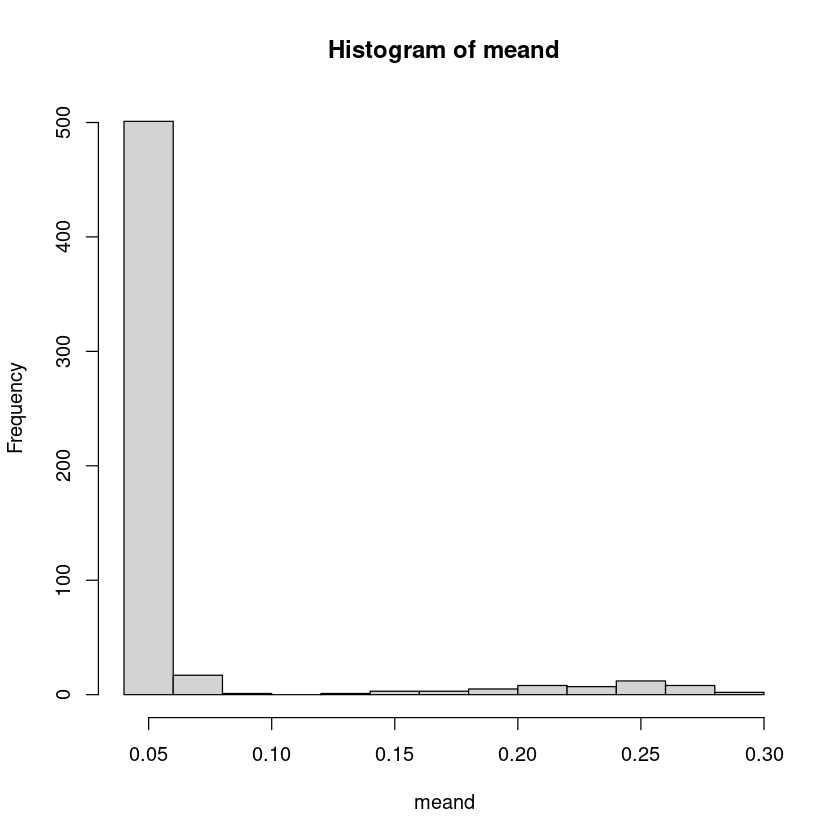

Joining with `by = join_by(sample)`


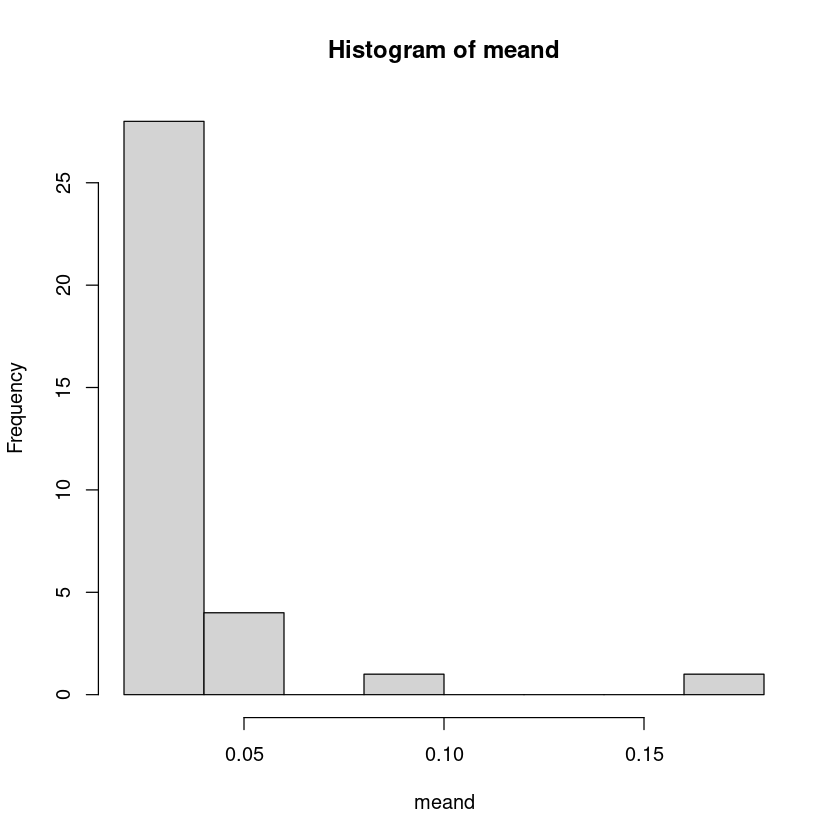

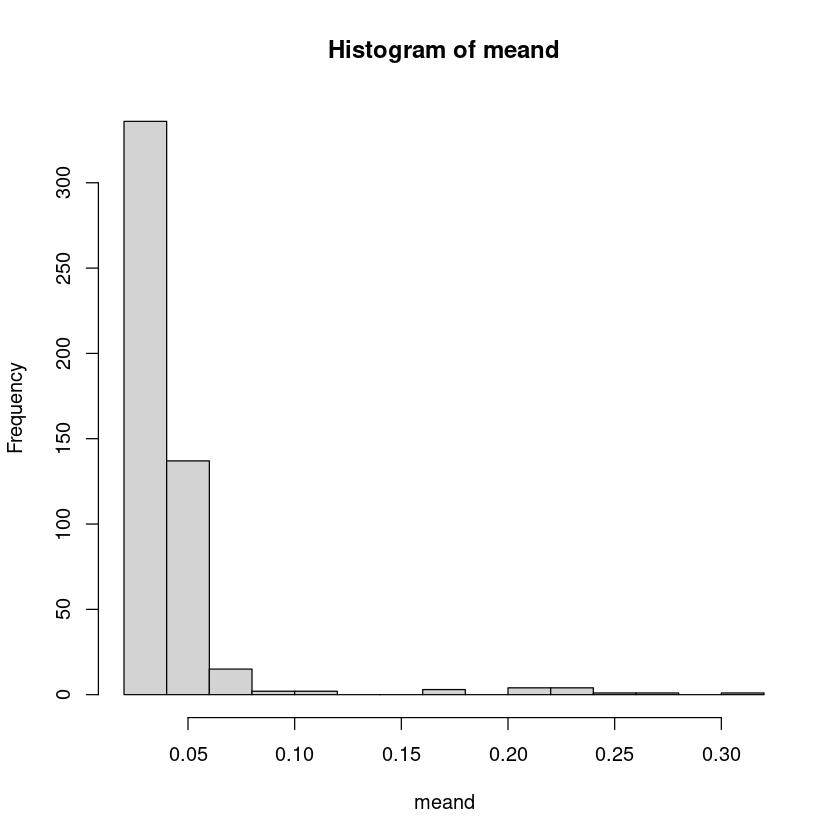

In [169]:
dists = meta %>%
    filter(!is.na(Section)) %>%
    group_by(Section) %>%
    group_map(distdendro)